# Homework 1

## Imports

To access the sentinel1 data via the openEO api the corresponding python client package is required. It can be installed from pip by running `pip install openeo` in a terminal with python installed. If you'd like to modify this script for your own needs see the documentation of the openEO Python Client at https://openeo.org/documentation/1.0/python/#full-example.

In [3]:
import openeo
import math
import os

## Authentication
When executing the Cell bellow a link will be printed to the console. Follow this link to authenticate with your login.

In [4]:
connection = openeo.connect("openeofed.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## Sanity Check
To check weather the connection is alive, we request all available data collections and filter for collections linked to Sentinel 1.

In [5]:
c_ids = filter(lambda x: x.startswith("SENTINEL1"), connection.list_collection_ids()) #filter connection list for any item that starts with "SENTINEL1"
for c_id in c_ids: #unfortunatly needed to print out filtering results
    print(c_id)

SENTINEL1_GRD
SENTINEL1_GLOBAL_MOSAICS


## Config
In the following Cell we define the temporal and spatial extent of our area of interest and the stride at which the area of interest is sliced into chunks. Additional month can be added to the list and the download will work with no problem. Changing the interval that will be averaged later would require code changes.

In [6]:
long_start = 3.5
long_end = 8.5
long_stride = 1

lat_start = 51.5
lat_end = 55.5
lat_stride = 1

months=['2024-05']

The Cell bellow calculates the coordinates for the chunks.

In [7]:
long_steps = [long_start + i * long_stride for i in range(math.ceil((long_end - long_start) / long_stride))]
lat_steps = [lat_start + i * lat_stride for i in range(math.ceil((lat_end - lat_start) / lat_stride))]

long_steps

[3.5, 4.5, 5.5, 6.5, 7.5]

The function defined bellow is used to automatically retry a given lambda up to n times if an error occurs during execution. This is used to make sure the download doesn't get interrupted by a network failure. However, it could be utilized for any operation that has a failure probability which cannot be easily mitigated.

In [8]:
def n_trys(n, function):
    for i in range(n): # try n times
        try:
            function() # execute lambda
            return
        except KeyboardInterrupt: # explicitly handle KeyboardInterrupt, otherwise we wouldn't be able to stop the execution conveniently
            raise KeyboardInterrupt
        except: # notify the user but retry for any other exception
            print(f"an exception occurred in try {i}")
    raise ConnectionError(f"Download function couldn't be completed successfully in {n} trys") # raise an exception if all n trys fail

## Main Loop
The following cell contains the main logic for downloading the data.

In [9]:
for month in months:
    for lat_step_start in lat_steps: #iterate over latitude steps
        lat_step_end = lat_step_start + lat_stride
        for long_step_start in long_steps: #iterate over longitude steps
            long_step_end = long_step_start + long_stride

            #this dict defines the current chunk
            bbox = {"west": long_step_start, "south": lat_step_start, "east": long_step_end, "north": lat_step_end}
            print(f"downloading {bbox}", end=" ") #some output for the user

            datacube = connection.load_collection( # config for the download
                "SENTINEL1_GRD",
                temporal_extent = month,
                spatial_extent = bbox,
                bands = ["VV","VH"],
            )

            data_slice = datacube.reduce_temporal("mean") # form the average over one month to get a stable and complete image

            # this data slug will be used to store the data
            file_slug = f"../data/sentinel1_grd/{month}/{lat_step_start}-{lat_step_end}/{long_step_start}-{long_step_end}/"

            # the following if blocks check whether a file has already been created and skips those. That means if you change something you either need to delete old data or define the slug / file postfix differently
            if not os.path.exists(file_slug + "vv.tif"):
                n_trys(5, lambda: data_slice.band("VV").download(file_slug + "vv.tif")) # stores the VV polarisation band
            print("vv", end=" ")

            if not os.path.exists(file_slug + "vh.tif"):
                n_trys(5, lambda: data_slice.band("VH").download(file_slug + "vh.tif")) # stores the VH polarisation band
            print("vh", end=" ")

            if not os.path.exists(file_slug + "vv&vh.tif"):
                combined_band = data_slice.reduce_bands("mean") # combines both bands by forming the average
                n_trys(5, lambda: combined_band.download(file_slug + "vv&vh.tif")) #stores both bands
            print("vv&vh")

downloading {'west': 3.5, 'south': 51.5, 'east': 4.5, 'north': 52.5} vv vh vv&vh
downloading {'west': 4.5, 'south': 51.5, 'east': 5.5, 'north': 52.5} vv vh vv&vh
downloading {'west': 5.5, 'south': 51.5, 'east': 6.5, 'north': 52.5} vv vh vv&vh
downloading {'west': 6.5, 'south': 51.5, 'east': 7.5, 'north': 52.5} vv vh vv&vh
downloading {'west': 7.5, 'south': 51.5, 'east': 8.5, 'north': 52.5} vv vh vv&vh
downloading {'west': 3.5, 'south': 52.5, 'east': 4.5, 'north': 53.5} vv vh vv&vh
downloading {'west': 4.5, 'south': 52.5, 'east': 5.5, 'north': 53.5} vv vh vv&vh
downloading {'west': 5.5, 'south': 52.5, 'east': 6.5, 'north': 53.5} vv vh vv&vh
downloading {'west': 6.5, 'south': 52.5, 'east': 7.5, 'north': 53.5} vv vh vv&vh
downloading {'west': 7.5, 'south': 52.5, 'east': 8.5, 'north': 53.5} vv vh vv&vh
downloading {'west': 3.5, 'south': 53.5, 'east': 4.5, 'north': 54.5} vv vh vv&vh
downloading {'west': 4.5, 'south': 53.5, 'east': 5.5, 'north': 54.5} vv vh vv&vh
downloading {'west': 5.5, 's

In [68]:
datacube = connection.load_collection( # config for the download
                "SENTINEL1_GRD",
                temporal_extent = ['2024-04-01', '2024-06-01'],
                spatial_extent = {"west": 3.57, "south": 51.58, "east": 4.10, "north": 51.77},
                bands = ["VV","VH"],
            )
data_slice = datacube.reduce_temporal("mean")
output_bytes = data_slice.download()

In [69]:
output_bytes[:50]

b'MM\x00*\x00\x00\x00\x08\x00\x12\x01\x00\x00\x04\x00\x00\x00\x01\x00\x00\x0ei\x01\x01\x00\x04\x00\x00\x00\x01\x00\x00\x08k\x01\x02\x00\x03\x00\x00\x00\x01\x00 \x00\x00\x01\x03\x00\x03'

In [70]:
#Bytes to numpy

import rasterio
import numpy as np
from rasterio.io import MemoryFile
import matplotlib.pyplot as plt

with MemoryFile(output_bytes) as memfile:
    with memfile.open() as dataset:
        data = dataset.read()
        crs = dataset.crs

print("Array shape:", data.shape)
print("CRS:", crs)

Array shape: (2, 2155, 3689)
CRS: EPSG:32631


In [71]:
#Data Statistics
print("dtype:", data.dtype)
print("min:", data.min())
print("max:", data.max())
print(np.percentile(data[0], [1, 5, 50, 95, 99]))

dtype: float32
min: 8.106893e-06
max: 1157.8124
[0.00735692 0.0088649  0.01995576 0.17343303 0.38317148]


In [77]:
#DB Conversion
data_db = 10 * np.log10(data)
vv_db = data_db[0]
vh_db = data_db[1]

print("dtype:", data.dtype)
print(f"min vv: {vv_db.min()}, min vh: {vh_db.min()}")
print(f"max vv: {vv_db.max()}, max vh: {vh_db.max()}")
print(f"percentiles vv: {np.percentile(vv_db, [1, 5, 50, 95, 99])}, vh: {np.percentile(vh_db, [1, 5, 50, 95, 99])}")

dtype: float32
min vv: -27.395320892333984, min vh: -50.91145324707031
max vv: 30.636383056640625, max vh: 12.566753387451172
percentiles vv: [-21.33304226 -20.52326202 -16.99931908  -7.60868158  -4.16606844], vh: [-35.86338448 -33.82136154 -28.50505447 -14.94639149 -12.79115646]


In [100]:
#Scale for Visualization
VV_MIN, VV_MAX = np.percentile(vv_db, [2, 98])
VH_MIN, VH_MAX = np.percentile(vh_db, [2, 98])

vv_visual = np.clip(vv_db, VV_MIN, VV_MAX)
vv_visual = (vv_visual - VV_MIN) / (VV_MAX - VV_MIN)

vh_visual = np.clip(vh_db, VH_MIN, VH_MAX)
vh_visual = (vh_visual - VH_MIN) / (VH_MAX - VH_MIN)

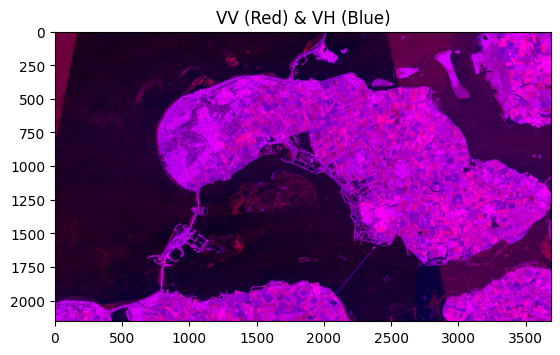

In [101]:
#Build RGB Frame and Visualize it
rgb = np.zeros((vv_visual.shape[0], vv_visual.shape[1], 3))
rgb[:, :, 0] = vv_visual
rgb[:, :, 2] = vh_visual

plt.imshow(rgb)
plt.title("VV (Red) & VH (Blue)")
plt.show()